# Hierarchical Attention Network
## Predict continuous values associated with graphs

### Vincent Jacob, Cyril Equilbec

## Imports

In [1]:
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Nadam, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Using TensorFlow backend.


## Global Variables

In [2]:
path_root = os.path.dirname(os.path.abspath('').replace('\\', '/'))
path_to_data = path_root + '/data/'
path_to_code = path_root + '/code/'
path_to_experiments = path_to_code + '/experiments/'
sys.path.insert(0, path_to_code)
for tgt in range(4):
    sys.path.insert(0, path_to_experiments + 'target_' + str(tgt))
    
from make_model_tgt0 import make_model_tgt0
from make_model_tgt1 import make_model_tgt1
from make_model_tgt2 import make_model_tgt2
from make_model_tgt3 import make_model_tgt3


models = [make_model_tgt0, make_model_tgt1, make_model_tgt2, make_model_tgt3]
is_GPU = True
save_hist = False
save_weights = True

# Preprocessing 

Those two cells will create 3 files which are documents.npy (baseline pseudo-documents) and documents_i.npy (optimal pseudo-documents generated for target i={0, 3}).

In [3]:
# Run this cell before running the notebook !
# it will compute the pseudo-documents using the baseline procedure
# we found that this method yielded corrects results for 2 targets

# !python ./baseline/preprocessing_baseline.py

In [4]:
# it will compute the pseudo-documents using our custom preprocessing method based on node2vec algorithms
!python ./experiments/preprocess_inputs.py

Creating pseudo-docs adapted to target 0...
documents generated for target 0
document array shape: (93719, 160, 11)
documents saved for target 0
everything done in 835.89s 

Creating pseudo-docs adapted to target 3...
documents generated for target 3
document array shape: (93719, 100, 13)
documents saved for target 3
everything done in 350.05s 



# CODE TO TRAIN ONE MODEL FOR A GIVEN TARGET

## Data Loading

In [ ]:
# precomputed documents (baseline)
docs = np.load(path_to_data + 'documents.npy')
# precomputed embbeding matrix (baseline)
embeddings = np.load(path_to_data + 'embeddings.npy')

###############################
# Target we want to train
tgt = 0
###############################


# Load training set and split it into train - validation sets
with open(path_to_data + 'train_idxs.txt', 'r') as file:
    train_idxs = file.read().splitlines()
    
train_idxs = [int(elt) for elt in train_idxs]

idxs_select_train = np.random.choice(range(len(train_idxs)), size=int(len(train_idxs) * 0.80), replace=False)
idxs_select_val = np.setdiff1d(range(len(train_idxs)), idxs_select_train)

train_idxs_new = [train_idxs[elt] for elt in idxs_select_train]
val_idxs = [train_idxs[elt] for elt in idxs_select_val]


docs = np.load(path_to_data + 'documents.npy')
docs_0 = np.load(path_to_data + 'documents_0.npy')
docs_3 = np.load(path_to_data + 'documents_3.npy')
dict_docs = {0 : docs_0, 1 : docs, 2 : docs, 3 : docs_3}

data = dict_docs[tgt]

docs_train = data[train_idxs_new, :, :]
docs_val = data[val_idxs, :, :]

# Load training and validation targets
with open(path_to_data + 'targets/train/target_' + str(tgt) + '.txt', 'r') as file:
    target = file.read().splitlines()
    
target_train = np.array([target[elt] for elt in idxs_select_train]).astype('float')
target_val = np.array([target[elt] for elt in idxs_select_val]).astype('float')


# Load test set
with open(path_to_data + 'test_idxs.txt', 'r') as file:
    test_idxs = file.read().splitlines()

test_idxs = [int(elt) for elt in test_idxs]
docs_test = docs[test_idxs, :, :]

## hyper-parameters

In [ ]:
# number of GRU units
n_units = 60
# mode by which outputs of the forward and backward RNNs will be combined.
merge_mode = 'concat'
drop_rate = 0.1
# droupout rate after embedding layer
drop_rate_emb = None
# whether to use cosine sim or not (unormalized dot product)
att_cosine = False
# whether to use a MLP for computing hidden attention state
use_dense_layer = True
# the activation function used by the MLP 
att_activation = 'tanh'
batch_size = 96
nb_epochs = 10
my_optimizer = Nadam()
my_patience = 6

###############################
# Training from scratch or not
pretrained = False
###############################

## Callbacks

In [ ]:
# stop the training if the loss doesn't improve up to 'my_patience' epochs
early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=my_patience,
                                   mode='min')

# save model corresponding to best epoch
checkpointer = ModelCheckpoint(filepath=path_to_data + 'model_' + str(tgt), 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True)

# reduce learning rate by 20% on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

## Training

In [ ]:
# Load the correct architecture according to target
make_model = models[tgt]

# Build a model according to the above hyperparameters
model = make_model(n_units, merge_mode, drop_rate, drop_rate_emb, 
                   att_cosine, att_activation, use_dense_layer, 
                   embeddings, docs_train, is_GPU)

print(model.summary())

if pretrained:
    model.load_weights(path_to_data + 'model_' + str(tgt))
    print("Weights loaded")
    

model.compile(loss='mean_squared_error',
                  optimizer=my_optimizer,
                  metrics=['mse'])
print("Model compiled")

# = = = = = training = = = = =

if save_weights:
    my_callbacks = [checkpointer, reduce_lr, early_stopping]
else:
    my_callbacks = [reduce_lr, early_stopping]
    
    

model.fit(docs_train, 
              target_train,
              batch_size = batch_size,
              epochs = nb_epochs,
              validation_data = (docs_val, target_val),
              callbacks = my_callbacks)
    

    
if save_hist:
    hist = model.history.history
    with open(path_to_data + 'model_history_' + str(tgt) + '.json', 'w') as file:
        json.dump(hist, file, sort_keys=False, indent=4)

print('* * * * * * * target', tgt, 'done * * * * * * *')    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 160, 11)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 160, 60)           21980055  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 160, 120)          43920     
_________________________________________________________________
attention_with_context_2 (At (None, 120)               14640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 60)                7260      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 61        
Total para

# CODE TO PREDICT ONE TARGET

In [ ]:
all_preds_han = []

indx_tg0 = [i for i in range(0, 18744)]
indx_tg1 = [i for i in range(18744, 37488)]
indx_tg2 = [i for i in range(37488, 56232)]
indx_tg3 = [i for i in range(56232,74976)]

idx = [indx_tg0, indx_tg1, indx_tg2, indx_tg3]

    
# prediction mode
drop_rate = 0.
drop_rate_emb = 0.
make_model = models[tgt]
model =  make_model(n_units, merge_mode, drop_rate, drop_rate_emb, 
                   att_cosine, att_activation, use_dense_layer, 
                   embeddings, docs_test, is_GPU)
    
model.load_weights(path_to_data + 'model_' + str(tgt))
all_preds_han.append(model.predict(docs_test).tolist())

# flatten
all_preds_han = [elt[0] for sublist in all_preds_han for elt in sublist]

# write the predictions of a single target with the corrects indx
with open(path_to_data + 'predictions_han_' + str(tgt) + '.txt', 'w') as file:
    if tgt == 0:
        file.write('id,pred\n')
    for id, pred in zip(idx[tgt], all_preds_han):
        pred = format(pred, '.7f')
        file.write(str(id) + ',' + pred + '\n')

# TRAINING ALL THE MODELS
## Each architecture should be in the correct folder

In [3]:
!python ./experiments/training_experiments.py

data loaded
model compiled

Epoch 00001: val_loss improved from inf to 0.39005, saving model to D:/Scolaire/Code/Python/Machine_Learning/Kaggle_Challenges_M2/HAN_Graphs/data/model_0

Epoch 00002: val_loss improved from 0.39005 to 0.32004, saving model to D:/Scolaire/Code/Python/Machine_Learning/Kaggle_Challenges_M2/HAN_Graphs/data/model_0

Epoch 00003: val_loss improved from 0.32004 to 0.27121, saving model to D:/Scolaire/Code/Python/Machine_Learning/Kaggle_Challenges_M2/HAN_Graphs/data/model_0

Epoch 00004: val_loss improved from 0.27121 to 0.23333, saving model to D:/Scolaire/Code/Python/Machine_Learning/Kaggle_Challenges_M2/HAN_Graphs/data/model_0

Epoch 00005: val_loss did not improve from 0.23333

Epoch 00006: val_loss improved from 0.23333 to 0.22883, saving model to D:/Scolaire/Code/Python/Machine_Learning/Kaggle_Challenges_M2/HAN_Graphs/data/model_0

Epoch 00007: val_loss improved from 0.22883 to 0.20769, saving model to D:/Scolaire/Code/Python/Machine_Learning/Kaggle_Challenge

Using TensorFlow backend.


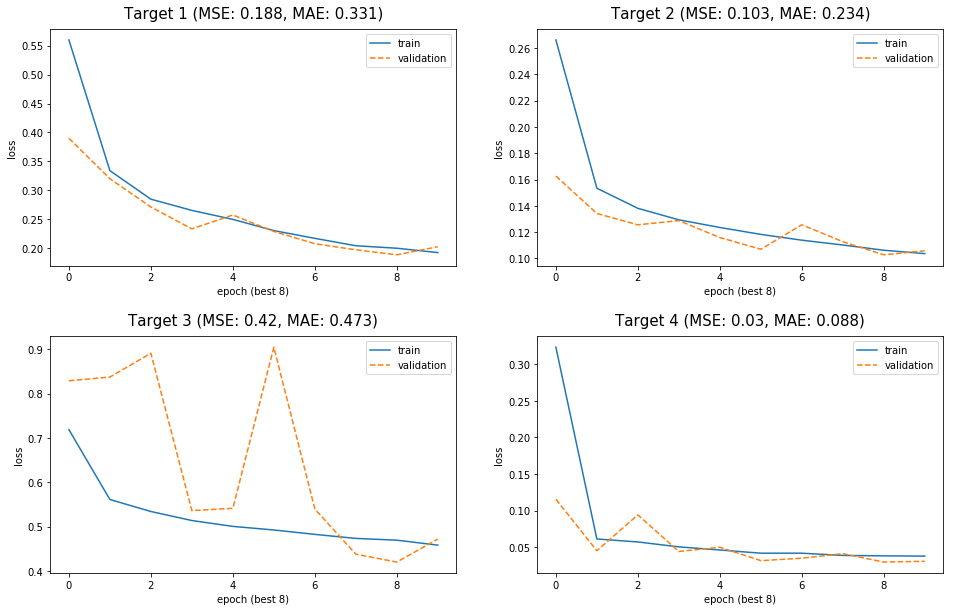

In [2]:
exec(open("read_results.py").read())
plt.show()

# Predict ALL TARGETS
## This will create a csv file with the proper Kaggle format

In [ ]:
!python ./experiments/predict_experiments.py

# Concatenate predictions of all targets
### You can use the following code to generate a proper csv file from 4 txt files containing individual predictions for each targets

In [ ]:
# def from_txt_to_csv(file_name, folder_name):
#     """
#     Transform the output of the read_results_predict.py in a proper Kaggle Submission, i.e : a well formated csv file
    
#     inputs : 
#     - file_name is the name (string) of the txt file generated by the read_results_predict.py (without the .txt extension)
#     - folder_name is the desired or existing name (string) of the folder where the submission will be stored into 
    
#     output : None
    
#     """
#     path_root = os.path.dirname(os.path.abspath('').replace('\\', '/')) + "/data/"
#     path_file = path_root  + file_name + ".txt"
#     path_folder = path_root + folder_name
#     # create a directory if it doesn't exist yet
#     if not os.path.exists(path_folder):
#         os.makedirs(path_folder)
      
#     df = pd.read_csv(path_file)
#     df.to_csv(path_folder + "/" + file_name + ".csv", index=False)
#     print("Submission saved in '{}'".format(path_folder))  

In [ ]:
# list of txt files containing predictions for each target
# filenames = [path_to_data + 'predictions_han_' + str(tgt) + '.txt' for tgt in range(4)]
# with open(path_to_data + 'predictions_all.txt', 'w') as outfile:
#     for fname in filenames:
#         with open(fname) as infile:
#             for line in infile:
#                 outfile.write(line)

# from_txt_to_csv('predictions_all', '')